In [1]:
import pandas as pd

tomatoes = pd.read_csv('../../datasets/rotten_tomatoes_train.tsv', sep='\t')
crime = pd.read_csv('../../datasets/sfcrime_train.csv')

In [4]:
tomatoes.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
crime.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


### Visualizing a TF/IDF Model

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(tomatoes.Phrase)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [13]:
X = vectorizer.transform(tomatoes.Phrase)
y = tomatoes.Sentiment

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
model = LogisticRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.61056004100986805

Next, we'll visualize the learned model using a wordcloud.  First, install the wordcloud generator using pip install.

`pip install wordcloud`

In [44]:
import wordcloud

def make_word_cloud(feature_names, coefficients):
    """ Create a word cloud with the words given by feature_names
        and given coefficients. """
    cloud = wordcloud.WordCloud()
    cloud.generate_from_frequencies(zip(feature_names, coefficients))
    return cloud.to_image()

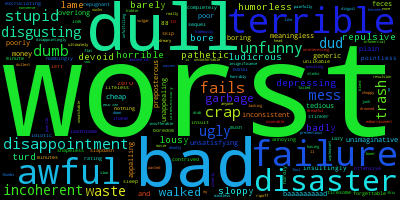

In [45]:
make_word_cloud(vectorizer.get_feature_names(), model.coef_[0,:])

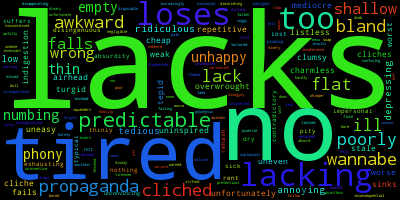

In [46]:
make_word_cloud(vectorizer.get_feature_names(), model.coef_[1,:])

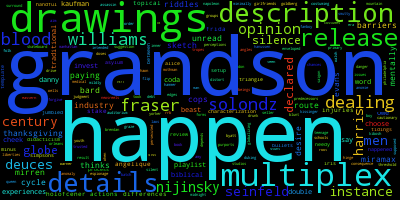

In [47]:
make_word_cloud(vectorizer.get_feature_names(), model.coef_[2,:])

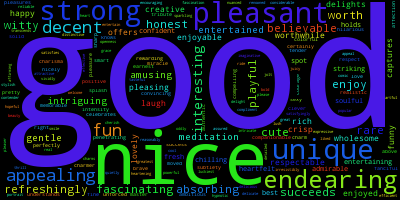

In [48]:
make_word_cloud(vectorizer.get_feature_names(), model.coef_[3,:])

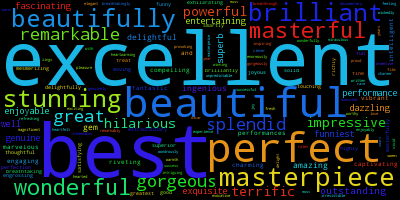

In [49]:
make_word_cloud(vectorizer.get_feature_names(), model.coef_[4,:])

In [68]:
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier(max_depth=4)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [69]:
export_graphviz(tree_model, feature_names=vectorizer.get_feature_names(), out_file='tree.dot')

In [70]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py
%load_ext gvmagic

Installed gvmagic.py. To use it, type:
  %load_ext gvmagic
The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


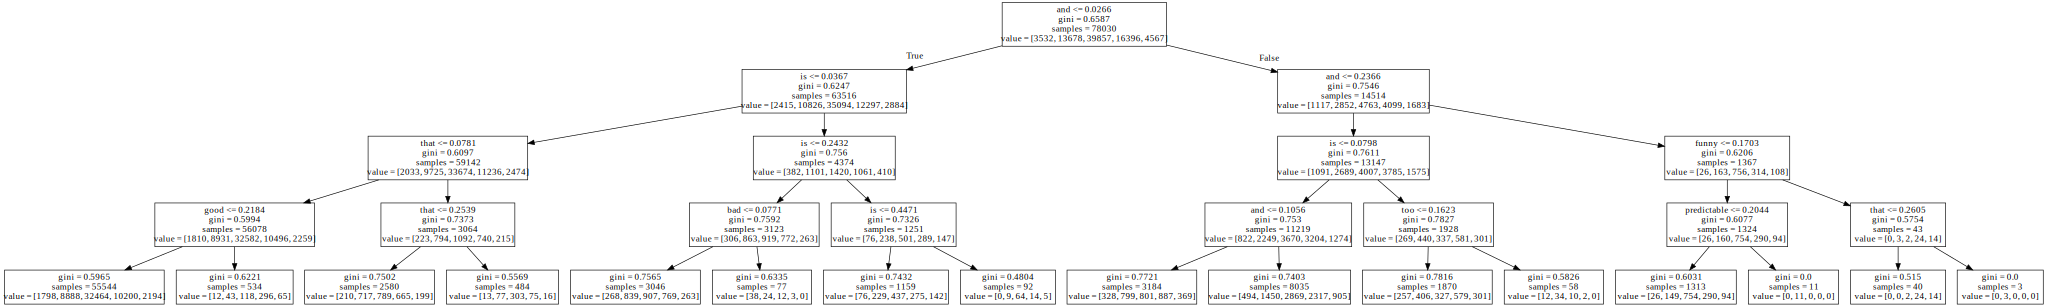

In [71]:
f = open('tree.dot')
tree_model_visualization = f.read()
f.close()
%dotstr tree_model_visualization

In [72]:
tree_model.score(X_test, y_test)

0.51540433166730748

If we look at the first node we are essentially using and as a proxy for a long phrase.  Long phrases are more likely to have polarized sentiment values.  Instead of making the algorithm do the work using TF-IDF, we can instead encode that feature directly.

In [104]:
import numpy as np
from scipy import sparse

num_words_feature = np.asarray(map(lambda x: len(x.split()), tomatoes.Phrase))
num_words_feature = num_words_feature[:, np.newaxis]
X_with_num_words = sparse.hstack((X, num_words_feature))
print X_with_num_words.shape

(156060, 15241)


In [108]:
tree_model_with_num_words = DecisionTreeClassifier(max_depth=4)
tree_model_with_num_words.fit(X_with_num_words, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

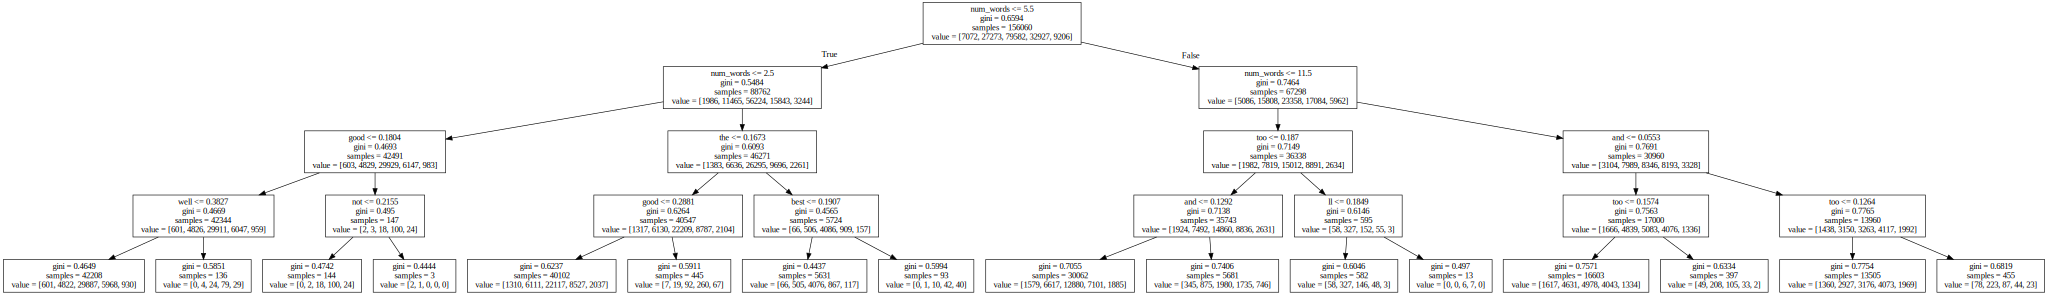

In [109]:
export_graphviz(tree_model_with_num_words,
                feature_names=vectorizer.get_feature_names() + ['num_words'],
                out_file='tree.dot')
f = open('tree.dot')
tree_model_visualization = f.read()
f.close()
%dotstr tree_model_visualization

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X_with_num_words, y, train_size=0.5)
tree_model_with_num_words = DecisionTreeClassifier(max_depth=3)
tree_model_with_num_words.fit(X_train, y_train)
tree_model_with_num_words.score(X_test, y_test)

0.51600666410354989

In [117]:
tree_model_with_num_words = DecisionTreeClassifier()
tree_model_with_num_words.fit(X_train, y_train)
tree_model_with_num_words.score(X_test, y_test)

0.53633217993079585

In [115]:
model = LogisticRegression()
model.fit(X_train, y_train)
print "With num words", model.score(X_test, y_test)

model_without_num_words = LogisticRegression()
model_without_num_words.fit(X_train[:,:-1], y_train)
print "Without num words", model_without_num_words.score(X_test[:,:-1], y_test)

With num words 0.619953863899
Without num words 0.61414840446


In [116]:
from sklearn.ensemble import RandomForestClassifier

forest_model_with_num_words = RandomForestClassifier()
forest_model_with_num_words.fit(X_train, y_train)
forest_model_with_num_words.score(X_test, y_test)

0.5994361143150071

In [179]:
import math
from sklearn.linear_model import LogisticRegressionCV

leaf_nodes = tree_model_with_num_words.apply(X_train)
models = {}
for k in set(leaf_nodes):
    models[k] = LogisticRegressionCV(Cs=[math.e**v for v in range(-5,5)])
    X_train_leaf = X_train[leaf_nodes == k, :]
    try:
        models[k].fit(X_train[leaf_nodes == k,:], y_train[(leaf_nodes == k)])
    except:
        # this node is completely pure, we need to do this otherwise we get an error
        models[k] = y_train[(leaf_nodes == k)].iloc[0]

/home/pruvolo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


In [180]:
leaf_nodes_test = tree_model_with_num_words.apply(X_test)
preds = np.zeros(y_test.shape)
for i, n in enumerate(leaf_nodes_test):
    if type(models[n]) == int:
        preds[i] = models[n]
    else:
        preds[i] = models[n].predict(X_test[i,:])[0]

In [187]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.61610918877354859

In [188]:
tuned_model = LogisticRegressionCV(Cs=[math.e**v for v in range(-5,5)])
tuned_model.fit(X_train, y_train)
tuned_model.score(X_test, y_test)

0.63214148404459825

Why are decision trees generally bad for sentiment analysis?  Plot probability of some sentiment versus TF-IDF value smoothed.  Show that this would be tough to model using trees.

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt
bad_index = vectorizer.get_feature_names().index('bad')

bad_floats = np.asarray(X_train[:,bad_index].todense())
buckets = np.digitize(bad_floats, np.arange(0,1,.1))

really_bad_rate = []
for i, v in enumerate(np.arange(0,1,.1)):
    really_bad_rate.append(np.sum((y_train[:, np.newaxis] == 4) * (buckets == i)) / float(sum(buckets == i)))

[nan, 0.058695848783576018, 0.0, 0.010752688172043012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


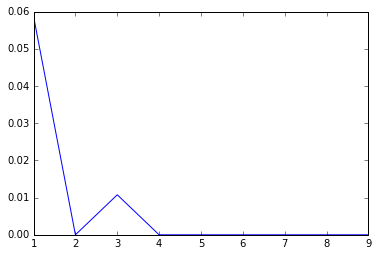

In [255]:
plt.plot(really_bad_rate)
print really_bad_rate